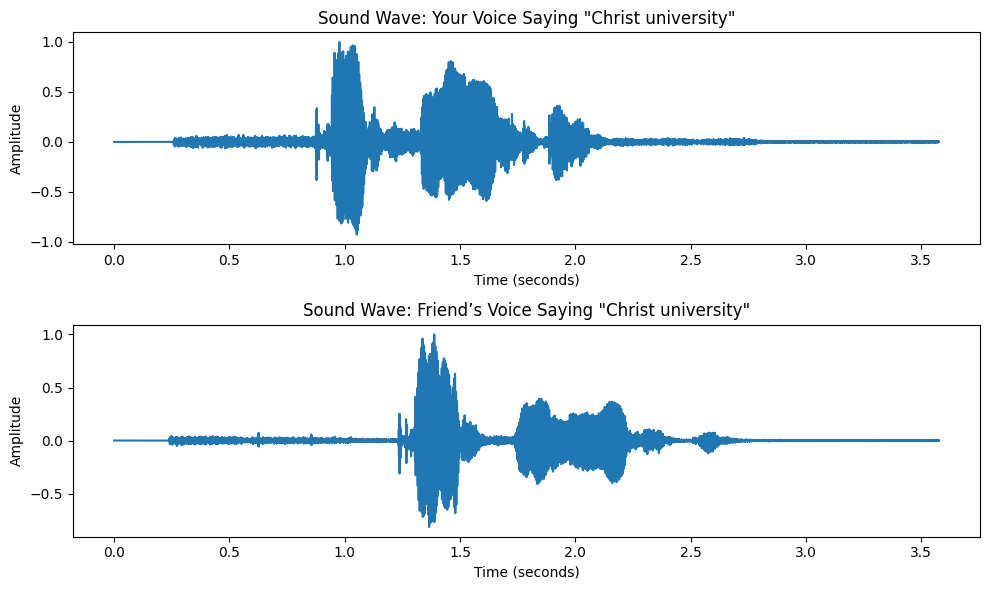

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample

# ---------------------------
# Load Your Two WAV Signals
# ---------------------------

sr1, sig1 = wavfile.read("signal1.wav")
sr2, sig2 = wavfile.read("signal2.wav")

# Convert int16 → float
if sig1.dtype.kind == 'i':
    sig1 = sig1 / np.iinfo(sig1.dtype).max
if sig2.dtype.kind == 'i':
    sig2 = sig2 / np.iinfo(sig2.dtype).max

# If stereo → convert to mono
if sig1.ndim > 1:
    sig1 = sig1.mean(axis=1)
if sig2.ndim > 1:
    sig2 = sig2.mean(axis=1)

# ---------------------------
# Normalize Both Signals
# ---------------------------

sig1 = sig1 - np.mean(sig1)
sig1 = sig1 / np.max(np.abs(sig1))

sig2 = sig2 - np.mean(sig2)
sig2 = sig2 / np.max(np.abs(sig2))

# ---------------------------
# Match Lengths (important for plotting)
# ---------------------------
min_len = min(len(sig1), len(sig2))
sig1 = sig1[:min_len]
sig2 = sig2[:min_len]

# Create time axis
t = np.linspace(0, min_len/sr1, min_len)

# ---------------------------
# Plot in same format as your sinusoidal example
# ---------------------------

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot your voice (signal1)
axs[0].plot(t, sig1)
axs[0].set_title('Sound Wave: Your Voice Saying "Christ university"')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Amplitude')

# Plot friend's voice (signal2)
axs[1].plot(t, sig2)
axs[1].set_title('Sound Wave: Friend’s Voice Saying "Christ university"')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


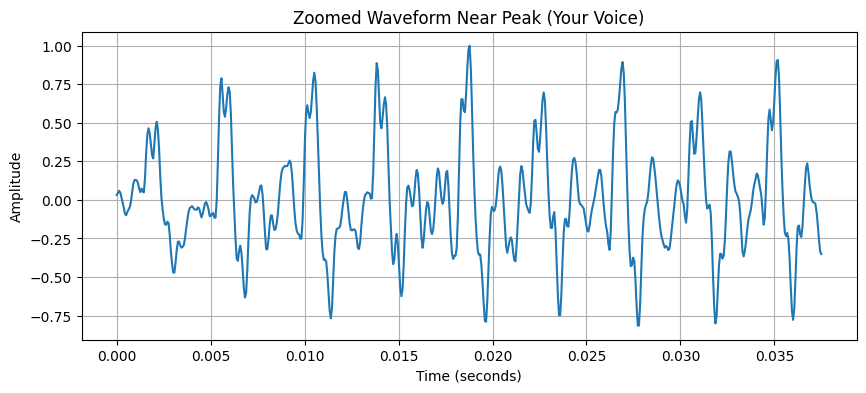

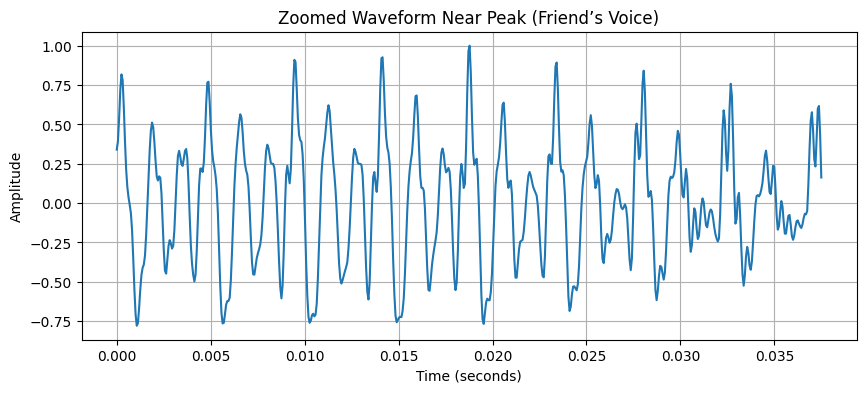

In [ ]:
# ---------------------------
# ZOOM AROUND PEAKS
# ---------------------------

window = 300  # samples on each side of the peak (adjustable)

# Find max peak index in each signal
peak1 = np.argmax(np.abs(sig1))
peak2 = np.argmax(np.abs(sig2))

# Extract windows around peaks
start1 = max(0, peak1 - window)
end1 = min(len(sig1), peak1 + window)

start2 = max(0, peak2 - window)
end2 = min(len(sig2), peak2 + window)

# Time axis for zoomed region
t_zoom1 = np.linspace(0, (end1-start1)/sr1, end1-start1)
t_zoom2 = np.linspace(0, (end2-start2)/sr2, end2-start2)

# ---------------------------
# PLOT ZOOMED PEAK REGIONS
# ---------------------------

plt.figure(figsize=(10, 4))
plt.plot(t_zoom1, sig1[start1:end1])
plt.title("Zoomed Waveform Near Peak (Your Voice)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t_zoom2, sig2[start2:end2])
plt.title("Zoomed Waveform Near Peak (Friend’s Voice)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

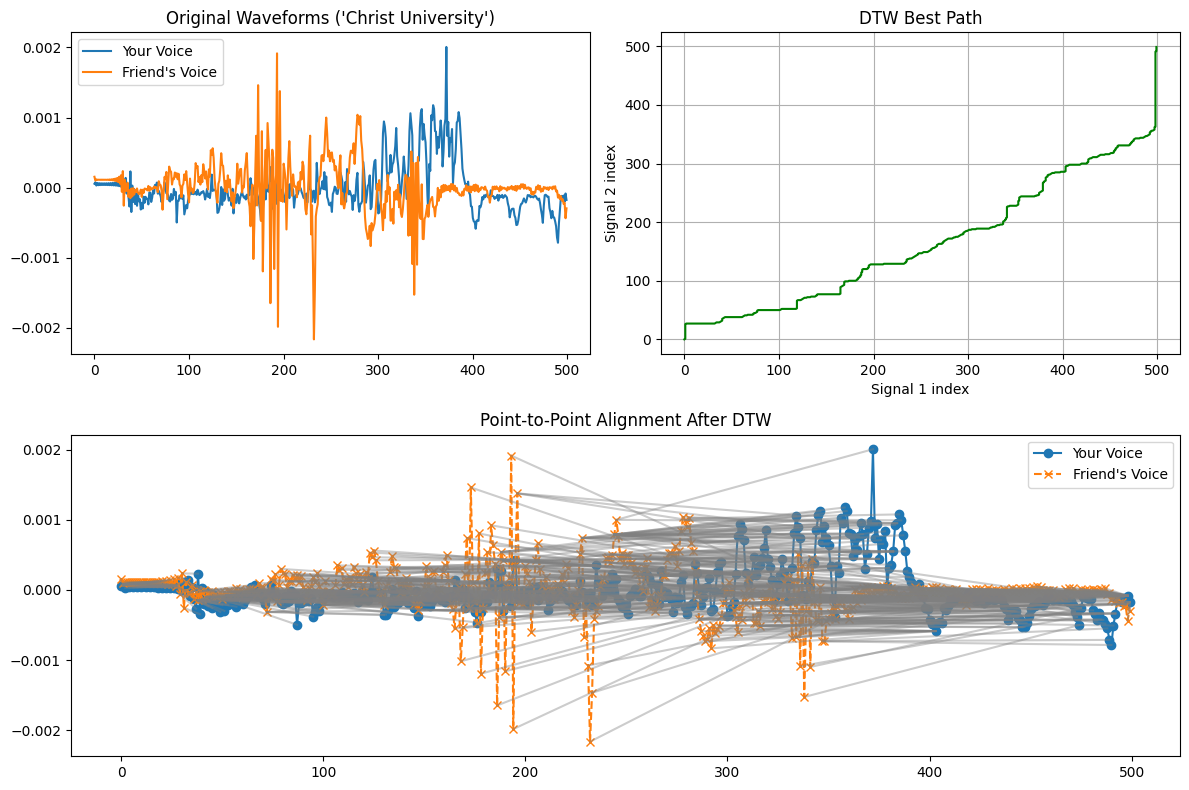

                 Metric         Value                     Description
0  DTW Similarity Score  4.488743e-08  Lower scores = more similarity


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample
import pandas as pd

# -----------------------------------------------------
# 1. LOAD REAL AUDIO SIGNALS
# -----------------------------------------------------

sr1, sig1 = wavfile.read("signal1.wav")
sr2, sig2 = wavfile.read("signal2.wav")

# Convert to float
if sig1.dtype.kind == 'i':
    sig1 = sig1 / np.iinfo(sig1.dtype).max
if sig2.dtype.kind == 'i':
    sig2 = sig2 / np.iinfo(sig2.dtype).max

# Mono conversion
if sig1.ndim > 1:
    sig1 = sig1.mean(axis=1)
if sig2.ndim > 1:
    sig2 = sig2.mean(axis=1)

# -----------------------------------------------------
# 2. NORMALIZE SIGNALS
# -----------------------------------------------------

sig1 = (sig1 - np.mean(sig1)) / np.max(np.abs(sig1))
sig2 = (sig2 - np.mean(sig2)) / np.max(np.abs(sig2))

# -----------------------------------------------------
# 3. RESAMPLE signals for equal length visualization
# -----------------------------------------------------

target_len = 500
sig1_rs = resample(sig1, target_len)
sig2_rs = resample(sig2, target_len)

# -----------------------------------------------------
# 4. PURE PYTHON DTW (NO EXTERNAL LIBRARY)
# -----------------------------------------------------

def dtw_distance(s1, s2):
    n, m = len(s1), len(s2)
    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = (s1[i-1] - s2[j-1])**2
            dtw[i, j] = cost + min(
                dtw[i-1, j],    # insertion
                dtw[i, j-1],    # deletion
                dtw[i-1, j-1]   # match
            )

    # Backtrack best path
    i, j = n, m
    path = []
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        steps = [dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1]]
        direction = np.argmin(steps)
        if direction == 0:
            i -= 1
        elif direction == 1:
            j -= 1
        else:
            i -= 1
            j -= 1
    path.reverse()

    return dtw[n, m], path

# Compute DTW
distance, best_path = dtw_distance(sig1_rs, sig2_rs)
similarity_score = distance / len(best_path)

# -----------------------------------------------------
# 5. PLOTS
# -----------------------------------------------------

plt.figure(figsize=(12, 8))

# Plot 1 — Original Signals
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(sig1_rs, label="Your Voice")
ax1.plot(sig2_rs, label="Friend's Voice")
ax1.set_title("Original Waveforms ('Christ University')")
ax1.legend()

# Plot 2 — DTW Path (index vs index)
ax2 = plt.subplot2grid((2, 2), (0, 1))
path_arr = np.array(best_path)
ax2.plot(path_arr[:, 0], path_arr[:, 1], 'g')
ax2.set_title("DTW Best Path")
ax2.set_xlabel("Signal 1 index")
ax2.set_ylabel("Signal 2 index")
ax2.grid(True)

# Plot 3 — Point-to-Point DTW Alignment
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(sig1_rs, label="Your Voice", marker='o')
ax3.plot(sig2_rs, label="Friend's Voice", marker='x', linestyle='--')

for a, b in best_path:
    ax3.plot([a, b], [sig1_rs[a], sig2_rs[b]], color='gray', alpha=0.4)

ax3.set_title("Point-to-Point Alignment After DTW")
ax3.legend()

plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 6. RESULTS TABLE
# -----------------------------------------------------

results_df = pd.DataFrame({
    'Metric': ['DTW Similarity Score'],
    'Value': [similarity_score],
    'Description': ['Lower scores = more similarity']
})

print(results_df)


Dynamic Time Warping (DTW) is an algorithm that measures the similarity between two temporal sequences that may vary in speed. It aligns the sequences non-linearly to find the optimal match, even if they are out-of-sync or of different lengths, by finding a "warping path" that minimizes the distance between them. DTW is widely used in applications like speech recognition, where a word can be spoken at different speeds, and in other fields such as finance and seismology.